In [1]:
%matplotlib inline

In [2]:
import rasterio
import rasterio.plot
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
import fiona

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import shapely
import folium

# Import requests and beautiful soup
import os
import shutil
import requests
from bs4 import BeautifulSoup


import cartopy.crs as ccrs
from glob import glob

https://www.huntsvilleal.gov/development/building-construction/gis/data-depot/

In [3]:
counties = fiona.open('./support/counties/cb_2017_us_county_500k.shp')

for county in counties:
    if county['properties']['NAME'] == 'Madison' and county['properties']['STATEFP'] == '01':
        break
        
madison = county
madison_boundary = shapely.geometry.shape(madison['geometry'])

In [4]:
flood = gpd.GeoDataFrame.from_file('./support/huntsville_flood/FIRM2018_Flood_poly.shp')
flood.head(3)

flood.crs
flood['area'] = flood.area
flood = flood.to_crs(epsg='4326')

In [5]:
flood = flood.sort_values('area', ascending = False)

In [6]:
xy = np.asarray(madison_boundary.centroid.xy).squeeze()
center = list(xy[::-1])
zoom = 11
m = folium.Map(location=center, zoom_start=zoom, control_scale=True)

#m.add_child(folium.GeoJson(madison_boundary.__geo_interface__, style_function=lambda x: {'color': 'red', 'alpha': 0}))
for (i, row) in flood.head(5).iterrows():
    g = folium.GeoJson(row.geometry.__geo_interface__)
    m.add_child(g)
m

In [7]:
import census_mapper
# From: http://andrewgaidus.com/Dot_Density_County_Maps/

In [8]:
al_tracts  = gpd.GeoDataFrame.from_file('./support/madison_tracts/cb_2015_01_tract_500k.shp')
al_tracts.head(5)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,003,010500,1400000US01003010500,01003010500,105,CT,17478851,155316,"POLYGON ((-87.802492 30.876487, -87.7996589999..."
1,01,003,011501,1400000US01003011501,01003011501,115.01,CT,38601084,100914,"POLYGON ((-87.71719399999999 30.407468, -87.71..."
2,01,009,050500,1400000US01009050500,01009050500,505,CT,248719996,1503784,"POLYGON ((-86.757347 33.977042, -86.755736 33...."
3,01,015,981901,1400000US01015981901,01015981901,9819.01,CT,63114223,142087,"POLYGON ((-86.013234 33.684258, -86.012238 33...."
4,01,025,957700,1400000US01025957700,01025957700,9577,CT,370173397,7613517,"POLYGON ((-88.18049499999999 31.820128, -88.17..."


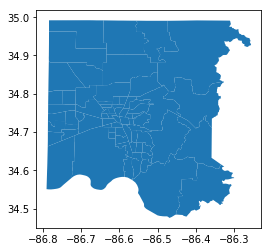

In [9]:
# From https://geomap.ffiec.gov/FFIECGeocMap/GeocodeMap1.aspx
mad_tracts = al_tracts[al_tracts['COUNTYFP'] == '089']
mad_tracts.plot()

In [10]:
madison_tract_income = census_mapper.get_census_variables(2015, 'acs5', 'tract', 
                                            {'county':'089', 'state':'01'}, 
                                            ['B19013_001E'], ['income'])['income'].dropna().astype(int)
madison_tract_income.head(10)

FIPS
01089000201    26413
01089000202    24375
01089000301    35965
01089000302    30393
01089000403    43636
01089000501    46167
01089000502    32089
01089000503    43922
01089000601    46771
01089000602    38474
Name: income, dtype: int64

In [11]:
mad_tracts_geo = mad_tracts.set_index("GEOID")['geometry'].to_crs(epsg=32618)

madison_gdf = gpd.GeoDataFrame(geometry=mad_tracts_geo, data=madison_tract_income)
madison_gdf.head(10)

,income,geometry
FIPS,,
01089000201,26413,POLYGON ((-561812.0282979305 3908228.543000311...
01089000202,24375,POLYGON ((-563023.7752223681 3908662.107950784...
01089000301,35965,POLYGON ((-563777.3092380743 3910393.394952415...
01089000302,30393,POLYGON ((-565486.3462821154 3910099.244122104...
01089000403,43636,POLYGON ((-570005.5419940413 3912829.992849416...
01089000501,46167,POLYGON ((-569145.1002634519 3911064.404829111...
01089000502,32089,POLYGON ((-568688.3606788958 3910184.855864926...
01089000503,43922,POLYGON ((-568278.3011404939 3909312.662017298...
01089000601,46771,POLYGON ((-568443.9084544273 3907801.597138142...


/usr/lib/python3/dist-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Madison County, AL - Median Household Income by Census Tract')

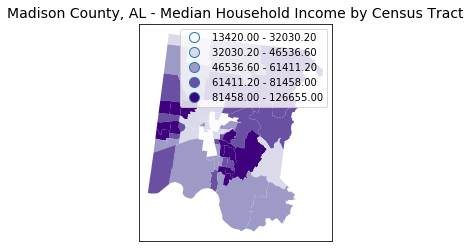

In [12]:
fig, ax = plt.subplots()
ax.set(aspect='equal', xticks=[], yticks=[])
madison_gdf.plot(column= 'income', ax = ax, scheme='QUANTILES', cmap='Purples', legend=True)
plt.title('Madison County, AL - Median Household Income by Census Tract', size = 14)

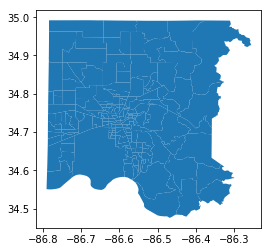

In [13]:
al_blocks = gpd.GeoDataFrame.from_file('./support/madison_tracts/cb_2015_01_bg_500k.shp')
al_blocks.head(5)
mad_blocks = al_blocks[al_blocks['COUNTYFP'] == '089']
mad_blocks.plot()
mad_blocks_geo = mad_blocks.set_index("GEOID")['geometry'].to_crs(epsg=32618)

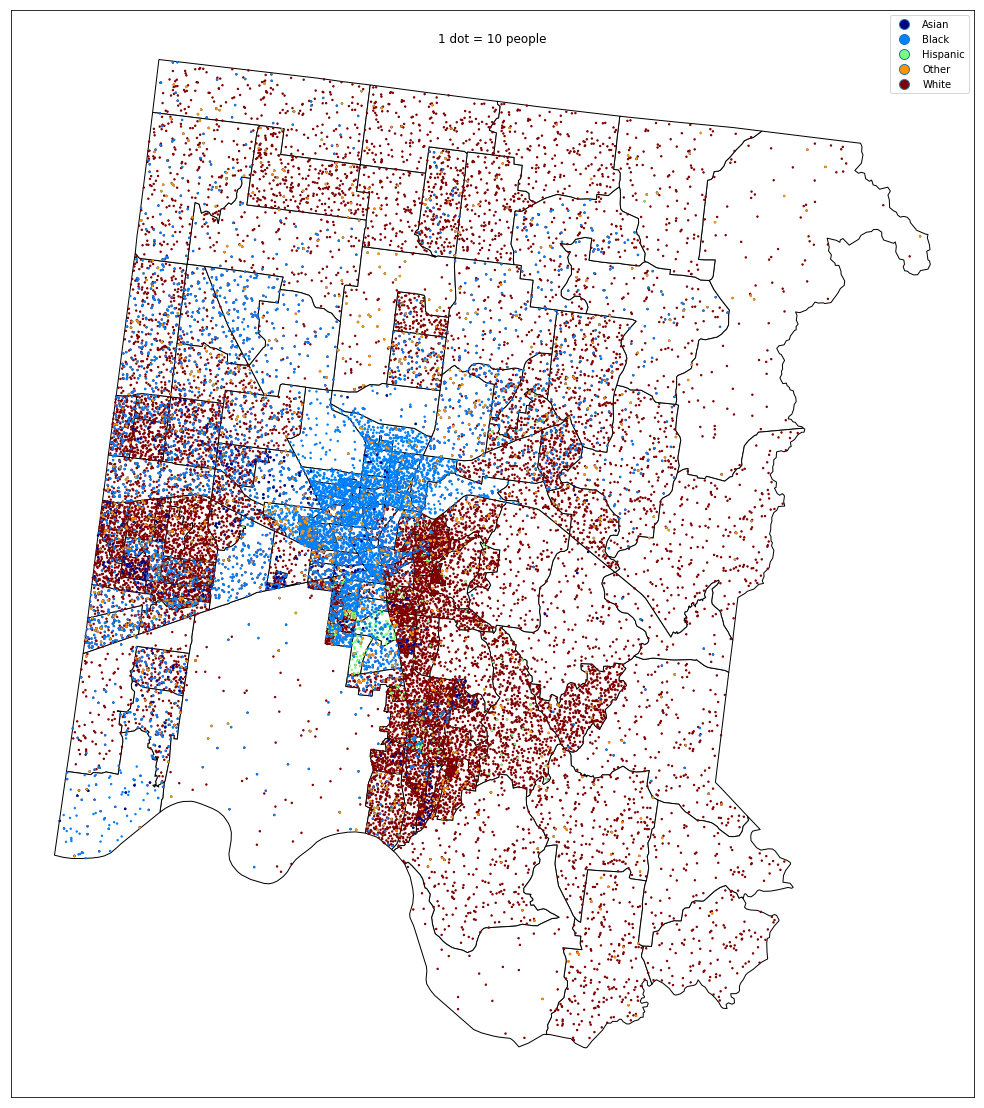

In [14]:
pts_per_person=10
dot_transparency=1.0
varlist = ['B03002_003E',
           'B03002_012E',
           'B03002_004E',
           'B03002_006E',
           'B03002_005E',
           'B03002_007E',
           'B03002_008E',
           'B03002_009E']
names = ['White',
         'Hispanic',
         'Black',
         'Asian',
         'AI/AN',
         'NH/PI',
         'Other_',
         'Two Plus']

#read in block group level census variables
dems = census_mapper.get_census_variables(2015, 'acs5', 'block group',
                                            {'county':'089', 'state':'01'}, varlist, names)
dems['Other']=dems[['AI/AN', 'NH/PI','Other_', 'Two Plus']].sum(1)

#Calculate county boundaries as the union of block groups
union = gpd.GeoSeries(mad_blocks_geo.unary_union)

fig, ax = plt.subplots(figsize=(20,20))
ax.set(aspect='equal', xticks=[], yticks=[])
union.plot(ax=ax, color='white')
ax.annotate("1 dot = {} people".format(pts_per_person),
            xy=(.5, .97), xycoords='axes fraction', horizontalalignment='center',
            fontsize = 12)
list_of_point_categories=[]
for field in ['White','Hispanic','Black','Asian','Other']:
    ps=gpd.GeoDataFrame(census_mapper.gen_points_in_gdf_polys(geometry = mad_blocks_geo, 
                                                              values=dems[field],
                             points_per_value = pts_per_person, seed=10))
    ps['field']=field
    list_of_point_categories.append(ps)
all_points=gpd.GeoDataFrame(pd.concat(list_of_point_categories))
all_points.plot(ax=ax, markersize=2, alpha=dot_transparency,
          column='field', categorical=True, legend=True, zorder=2, cmap='jet')
mad_blocks_geo.plot(ax=ax, facecolor='white', edgecolor='black')


In [18]:
dems = census_mapper.get_census_variables(2015, 'acs5', 'block group',
                                            {'county':'089', 'state':'01'}, ['B19013_001E'], ["income"])
madison_gdf = gpd.GeoDataFrame(geometry=mad_blocks_geo, data=dems)

madison_gdf = madison_gdf.dropna()



Text(0.5,1,'Madison County, AL - Median Household Income by Census Tract')

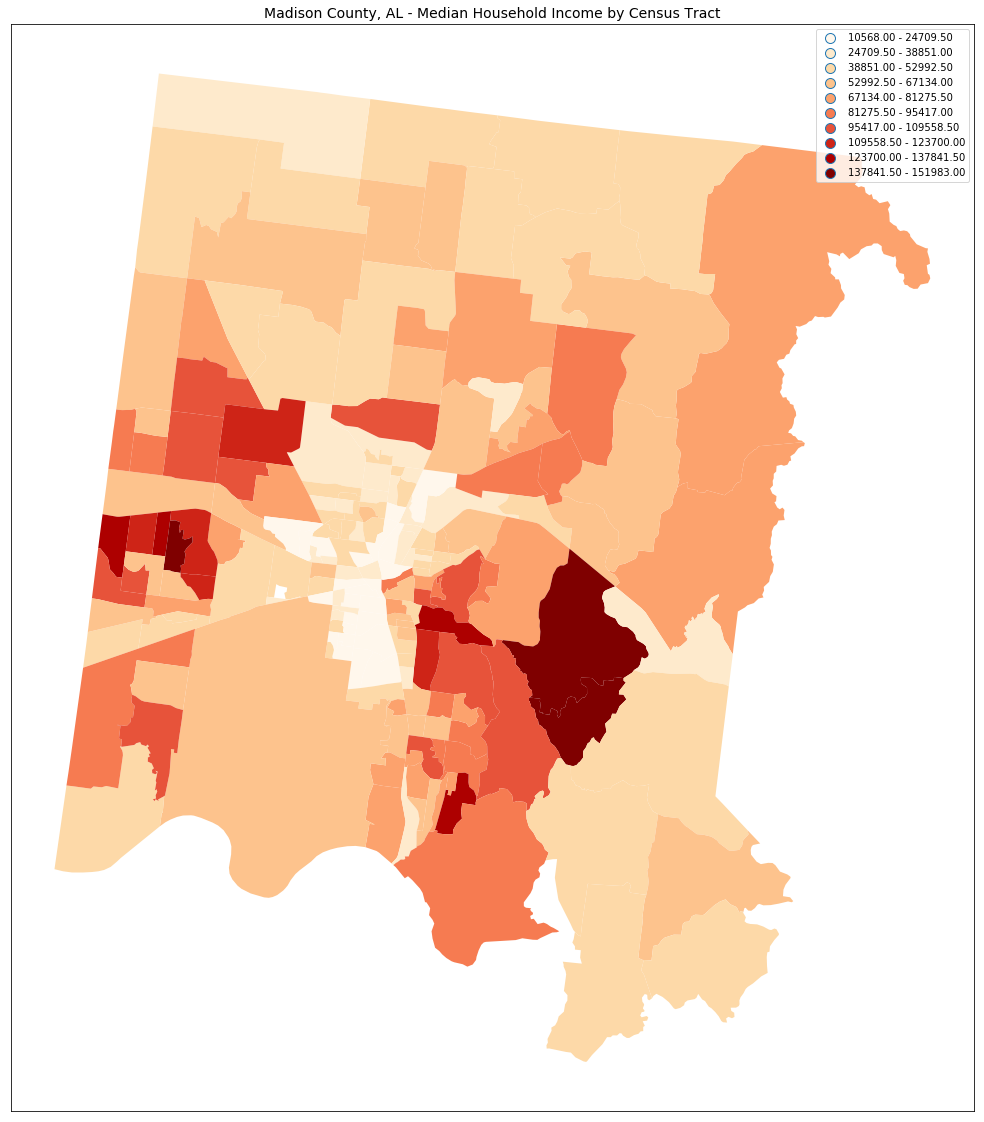

In [19]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set(aspect='equal', xticks=[], yticks=[])
madison_gdf.plot(column= 'income', ax = ax, cmap='OrRd', scheme='equal_interval', legend=True, k = 10)
plt.title('Madison County, AL - Median Household Income by Census Tract', size = 14)

In [17]:
dems = census_mapper.get_census_variables(2017, 'acs5', 'block group',
                                            {'county':'089', 'state':'01'}, ['B19013_001E', 'B25087_001E'], ["income", "mortgage"])
madison_gdf = gpd.GeoDataFrame(geometry=mad_blocks_geo, data=dems)

madison_gdf = madison_gdf.dropna()

madison_gdf['perc'] = madison_gdf['mortgage']/(madison_gdf['income']/12.0)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

KeyError: 'perc'

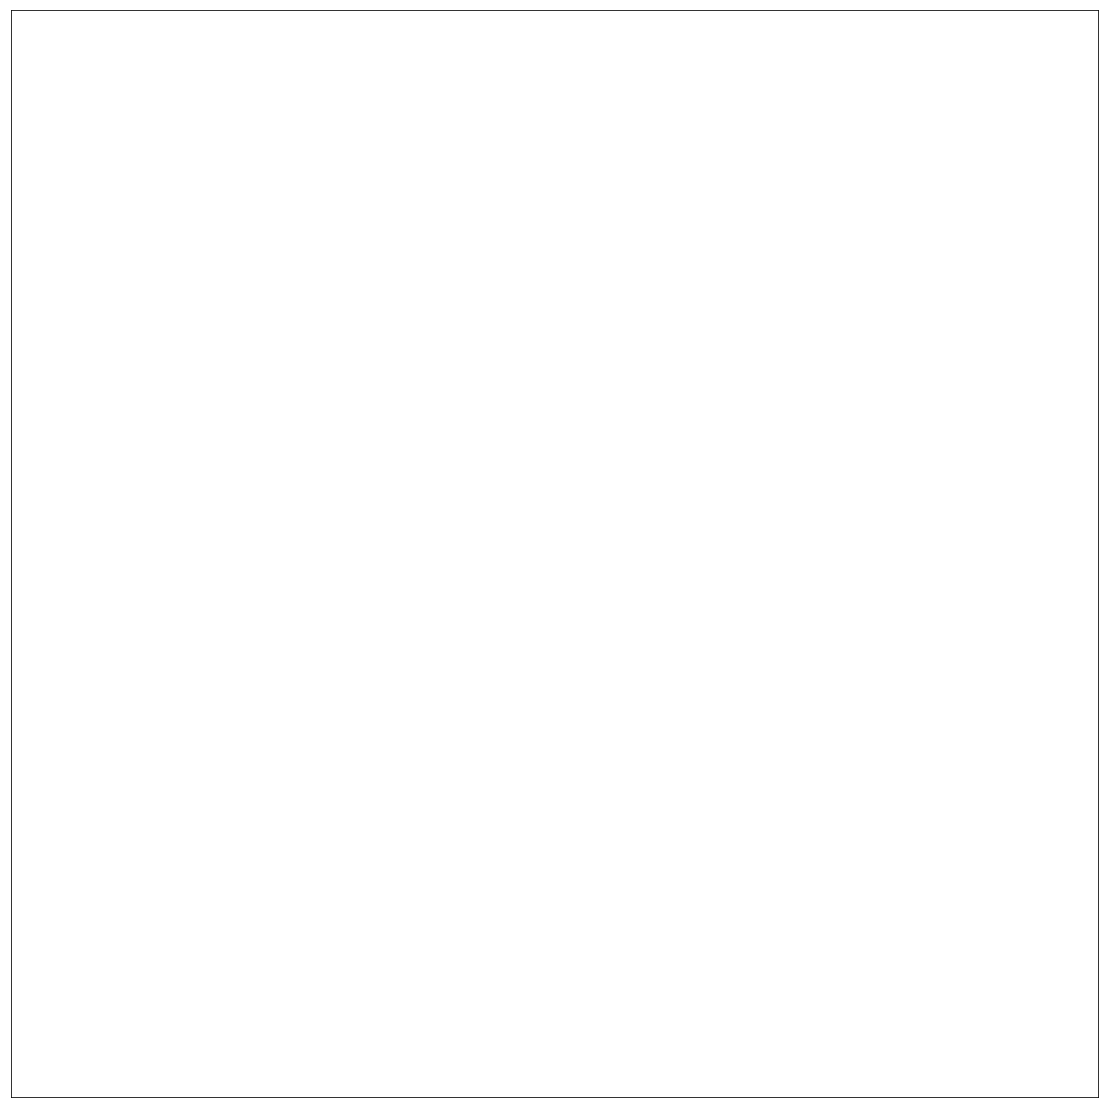

In [20]:
madison_gdf = madison_gdf.dropna()
fig, ax = plt.subplots(figsize=(20,20))
ax.set(aspect='equal', xticks=[], yticks=[])
madison_gdf.plot(column= 'perc', ax = ax, cmap='jet', scheme='fisher_jenks', legend=True, k = 10)
plt.title('Madison County, AL - Monthly Mortgage by Census Tract', size = 14)